In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.integrate import simps
from scipy.optimize import brentq

import sys
import dill

from functools import partial
import os

In [2]:
sys.path.append('..')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [4]:
labelsize = 18
titlesize = 20

In [5]:
from finance.discountfactor import ConstantRateDiscountFactor

r = 0.02
discount = ConstantRateDiscountFactor(r)

In [6]:
from matplotlib.ticker import FuncFormatter

formatter_tex_bps = FuncFormatter(lambda y, pos: "$%.0f$" % (10**4 * y))

def formatter_tex_time(x, pos):
    if x == 0.:
        return r'$\rm{0 \, y}$'
    
    str_x = str(x)
    
    if str_x[-1] == '0':
        return r'$\rm{%s \, y}$' % (str_x[:-2])

    return r'$\rm{%s \, y}$' % (str_x)

formatter_tex_time = FuncFormatter(formatter_tex_time)

In [7]:
LOIM_PATH = './res/aggregated/loss_over_im'
CVA_PATH = './res/aggregated/cva_ccp'

maturity = 5.

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [8]:
def str_quantile(x):
    q = x * 100
    str_q = '%.2f' % q
    if str_q[-1] == '0':
        return str_q[:-2] + '%'
    
    return str_q + '%'

In [9]:
def var_es(q_im, q):
    res = {}
    for t0, t1 in zip(times_cva, shifted_times_cva):
        inv_beta_t0 = 1. / discount(t0)
        
        res[t0] = {}
        
        str_int = '[%.2f, %.2f]' % (t0, t1)
        fname = 'loim_%s_%s.csv' % (str_int, q_im)
        loim_q_path = os.path.join(LOIM_PATH, fname)
        loim_df = pd.read_csv(loim_q_path, header=0, index_col=0)
    
        loim_ser_no_cva = loim_df.sum(axis=1)
        loim_ser = loim_ser_no_cva.copy()
       
        var_no_cva = loim_ser_no_cva.quantile(q, interpolation='linear')
        es_no_cva = loim_ser_no_cva[loim_ser_no_cva >= var_no_cva].mean() * inv_beta_t0
        
        res[t0][r'$\rm{\mathbb{ES}}^{\sharp} \, \, %s\%%$' % (q * 100)] = es_no_cva
        
        fname = '%s/cva_%.2f.csv' % (q_im, t0)
        cva_q_path_t0 = os.path.join(CVA_PATH, fname)
        cva_t0_df = pd.read_csv(cva_q_path_t0, header=0, index_col=0)
        
        fname = '%s/cva_%.2f.csv' % (q_im, t1)
        cva_q_path_t1 = os.path.join(CVA_PATH, fname)
        cva_t1_df = pd.read_csv(cva_q_path_t1, header=0, index_col=0)
        
        loim_ser += discount(t1) * cva_t1_df.sum(axis=1)
        loim_ser -= discount(t0) * cva_t0_df.sum(axis=1)
        
        var = loim_ser.quantile(q, interpolation='linear')
        es = loim_ser[loim_ser >= var].mean()
        
        res[t0][r'$\rm{\mathbb{V}ar} \, \, %s\%%$' % (q * 100)] = var * inv_beta_t0
        res[t0][r'$\rm{\mathbb{ES}} \, \, %s\%%$' % (q * 100)] = es * inv_beta_t0
        
    return pd.DataFrame(res).transpose()

In [10]:
SHAPES = ['-s', '--^', ':o']

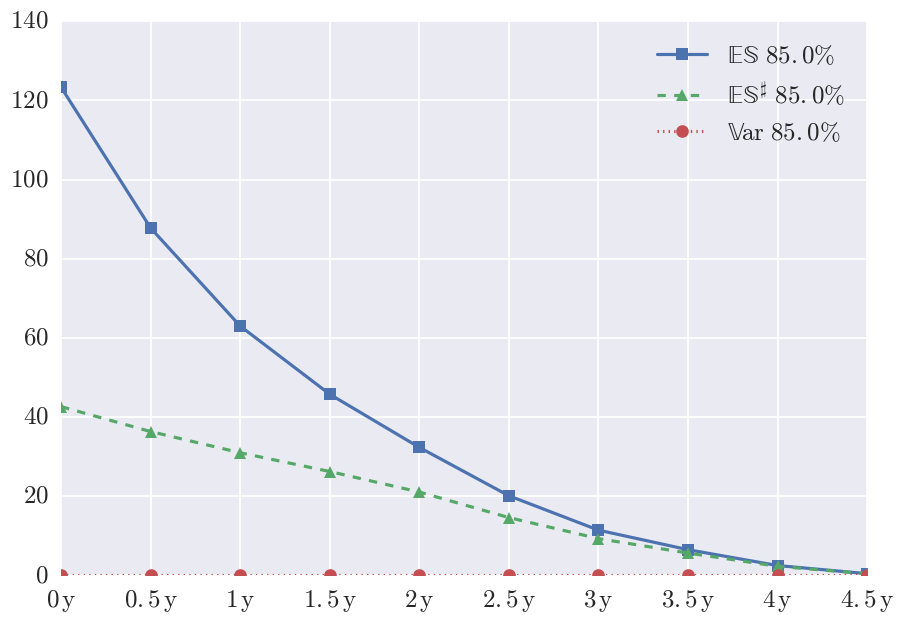

In [11]:
var_es_df = var_es(0.85, 0.85)

columns = var_es_df.columns
for col, shape in zip(columns, SHAPES):
    plt.plot(var_es_df.index, var_es_df[col], shape, label=col)

plt.gca().xaxis.set_major_formatter(formatter_tex_time)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

##plt.title(r'$\rm{IM \, level \, at} \, 85\%%$', fontsize=titlesize)

plt.legend(fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.show()

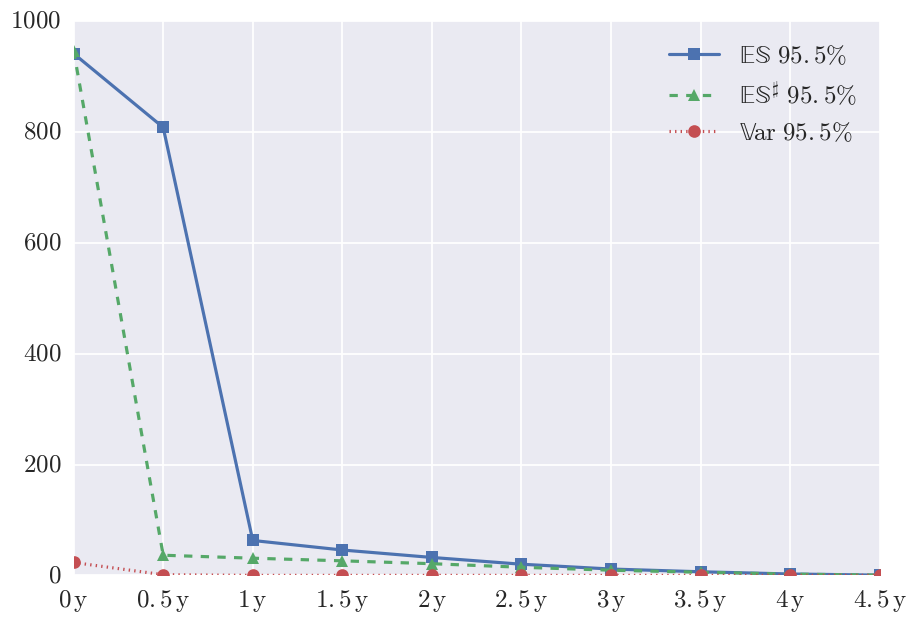

In [12]:
var_es_df = var_es(0.85, 0.955)

columns = var_es_df.columns
for col, shape in zip(columns, SHAPES):
    plt.plot(var_es_df.index, var_es_df[col], shape, label=col)

plt.gca().xaxis.set_major_formatter(formatter_tex_time)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

##plt.title(r'$\rm{IM \, level \, at} \, 85\%%$', fontsize=titlesize)

plt.legend(fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.show()

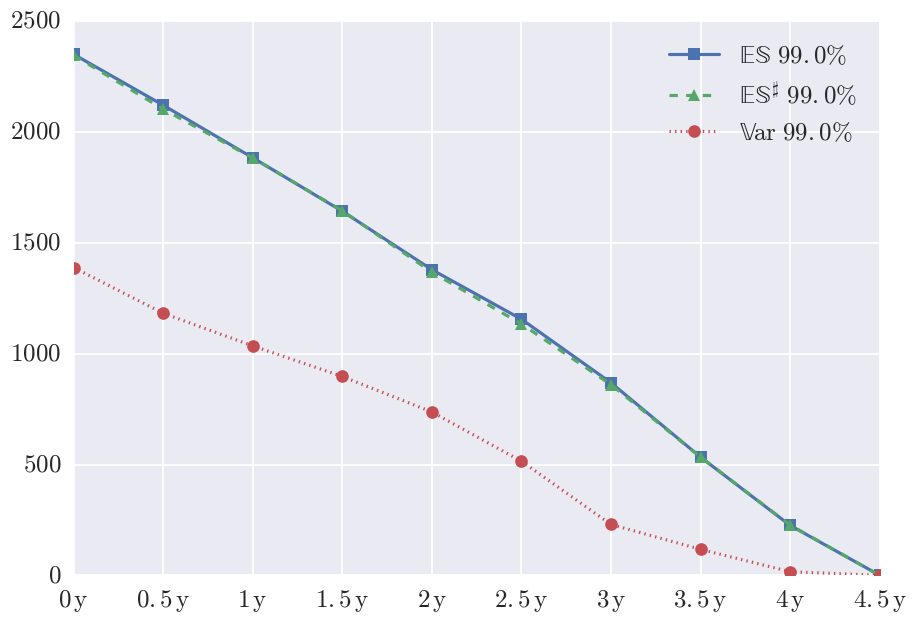

In [13]:
var_es_df = var_es(0.85, 0.99)

columns = var_es_df.columns
for col, shape in zip(columns, SHAPES):
    plt.plot(var_es_df.index, var_es_df[col], shape, label=col)

plt.gca().xaxis.set_major_formatter(formatter_tex_time)
plt.gca().yaxis.set_major_formatter(formatter_tex_bps)

##plt.title(r'$\rm{IM \, level \, at} \, 85\%%$', fontsize=titlesize)

plt.legend(fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.show()

In [15]:
var_es_df * 10000

,"$\rm{\mathbb{ES}} \, \, 99.0\%$","$\rm{\mathbb{ES}}^{\sharp} \, \, 99.0\%$","$\rm{\mathbb{V}ar} \, \, 99.0\%$"
0.0,2350.932440,2346.118424,1388.899004
0.5,2121.181639,2103.551712,1182.471431
1.0,1884.052880,1882.928300,1035.316484
1.5,1642.766685,1644.844424,897.387488
2.0,1379.163346,1367.966274,737.182176
2.5,1155.746158,1134.324032,514.945487
3.0,868.856333,860.390347,229.738226
3.5,533.661248,533.857046,117.276448
4.0,225.461139,226.876115,16.613678
4.5,0.423731,0.405023,0.000000
